In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128

train_dataset = datasets.MNIST('./data', train=True, download = True, 
                               transform = transforms.Compose([
                                                               transforms.ToTensor(),
                                                               transforms.Normalize((0.1307,), (0.3081, ))
                               ]))

test_dataset = datasets.MNIST('./data', train=False, download = True, 
                               transform = transforms.Compose([
                                                               transforms.ToTensor(),
                                                               transforms.Normalize((0.1307,), (0.3081, ))
                               ]))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

50000 10000 10000


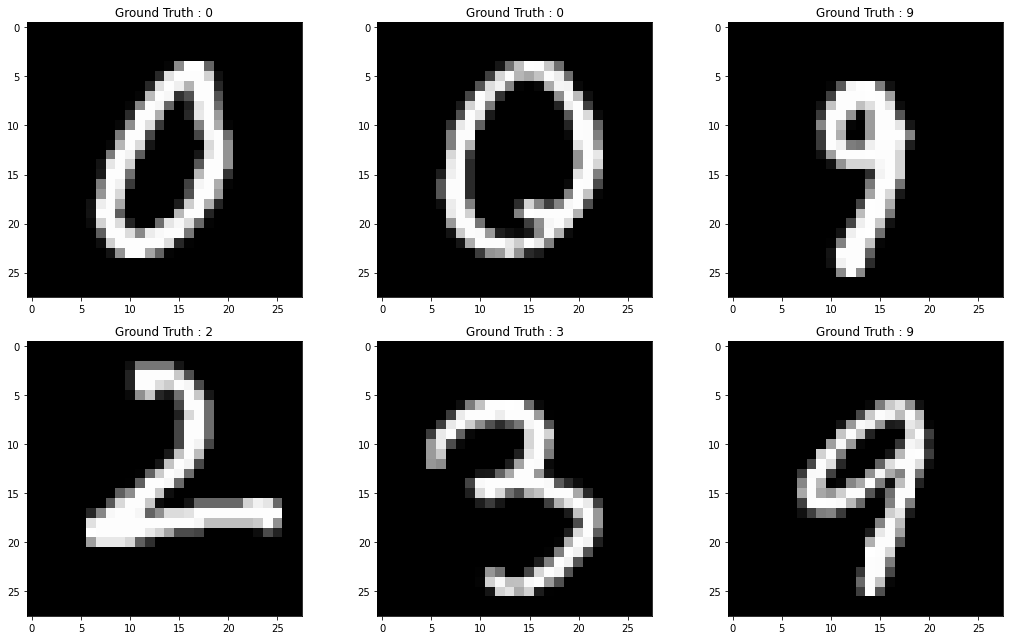

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,9))

for i in range(6):
  plt.subplot(2,3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(f'Ground Truth : {example_targets[i]}')
plt.show()

In [ ]:
# Model Architecture 설계
import torch.nn.functional as F


class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = 5, stride=1, padding= 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride=2)

    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size =5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride= 2)
    )
    self.dropout = nn.Dropout() # 비율 은 ?
    self.fc1 = nn.Linear(in_features = 7 * 7 * 64, out_features =1000) # FullyConnected
    self.fc2 = nn.Linear(in_features = 1000, out_features = 10)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.reshape(x.size(0), -1) #??
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:

# nn.ModuleList 로 List로 만들어줘야 PyTorch에서 Gradient Descent를 지정해준다.

class MLPModel(nn.Module):
  def __init__(self, hideen_nodes):
    super(MLPModel, self).__init__()
    nodes = (784, ) + hidden_nodes + (10,)
    depth = len(nodes)
    linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(depth-1)]
    self.linears = nn.ModuleList(linears)
    self.relu = nn.ReLU()
    self.depth = depth

  def forward(self, x ):
    for linear in self.linears:
      x = linear(x)
      x = self.relu(x)
    return x 





In [20]:
# Optimizer, Lossfunction 정의
import torch.optim as optim
from sklearn.metrics import accuracy_score

# lr Tunning
# learning_rate = [0.001, 0.005, 0.0001, 5e-05]
learning_rate  = 0.005 

hidden_nodes = (200, 150, 100, 50)

model = MLPModel(hidden_nodes)

critertion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

list_epoch = []
list_train_loss = []
list_val_loss =[]

list_acc = []
list_acc_epoch = []

epoch = int(input('Epoch를 입력해주세요 >> '))


for i in range(epoch):
  train_loss = 0
  model.train()

  for input_X, true_y in train_loader:
    optimizer.zero_grad()

    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X)

    loss = critertion(pred_y.squeeze(), true_y) # size 맞춰주고
    loss.backward()
    optimizer.step()
    train_loss += loss.detach().numpy()
  train_loss = train_loss / len(train_loader)
  list_train_loss.append(train_loss)
  list_epoch.append(i)

  # Validation
  val_loss = 0
  model.eval()
  with torch.no_grad():
    for input_X, true_y in val_loader:
      input_X = input_X.squeeze()
      input_X = input_X.view(-1, 784)
      pred_y = model(input_X)

      loss = critertion(pred_y.squeeze(), true_y)
      val_loss += loss.detach().numpy()
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)

    # Evaluation
    correct = 0
    model.eval()
    with torch.no_grad():
      for input_X, true_y in test_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
        correct += pred_y.eq(true_y).sum()

      acc = correct.numpy() / len(test_loader.dataset)
      list_acc.append(acc)
      list_acc_epoch.append(i)

    print(f'Epoch : {i}, Train Loss : {train_loss}, Val Loss : {val_loss} Test Acc : {acc* 100}%')



Epoch를 입력해주세요 >> 10
Epoch : 0, Train Loss : 0.31839001634160574, Val Loss : 0.16005464192904248 Test Acc : 95.32000000000001%
Epoch : 1, Train Loss : 0.1375766136657323, Val Loss : 0.12803584643745725 Test Acc : 96.74000000000001%
Epoch : 2, Train Loss : 0.10298693361108566, Val Loss : 0.1643885084533993 Test Acc : 96.19%
Epoch : 3, Train Loss : 0.08626468227390209, Val Loss : 0.11332855518624375 Test Acc : 97.17%
Epoch : 4, Train Loss : 0.08613517396914228, Val Loss : 0.1417106610923251 Test Acc : 96.77%
Epoch : 5, Train Loss : 0.07125773349100405, Val Loss : 0.12751028831765243 Test Acc : 96.71%
Epoch : 6, Train Loss : 0.06684458634370695, Val Loss : 0.12456266001998624 Test Acc : 97.1%
Epoch : 7, Train Loss : 0.05682721396293634, Val Loss : 0.1167489529846684 Test Acc : 97.19%
Epoch : 8, Train Loss : 0.055914860057985155, Val Loss : 0.12616082112882523 Test Acc : 97.3%
Epoch : 9, Train Loss : 0.0496711270893207, Val Loss : 0.12065301716469135 Test Acc : 97.39%


Text(0.5, 1.0, 'Epoch vs Accuracy')

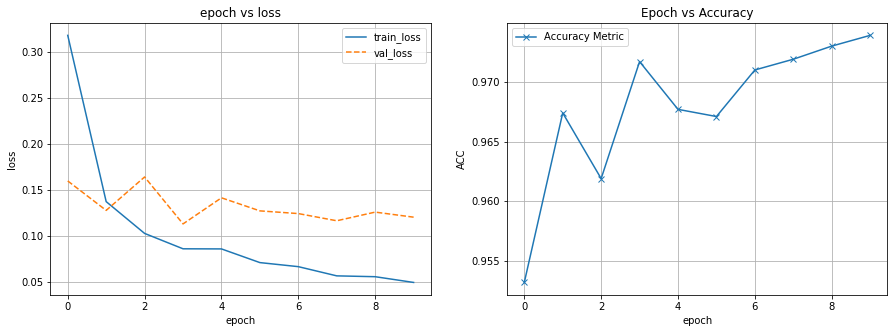

In [21]:
# Report

fig , axes= plt.subplots(1,2, figsize=(15,5))


axes[0].plot(list_epoch, list_train_loss, label='train_loss')
axes[0].plot(list_epoch, list_val_loss, '--', label='val_loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].grid()
axes[0].legend()
axes[0].set_title('epoch vs loss')

axes[1].plot(list_acc_epoch, list_acc , marker='x', label='Accuracy Metric')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('ACC')
axes[1].grid()
axes[1].legend()
axes[1].set_title('Epoch vs Accuracy')
                                                                             